In [1]:
import pandas as pd
import numpy as np
import pyemma as pm
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

## Introduction

This notebook makes a simple MSM from reaction coordinates identified by KR and defined in `exploratory/reaction_coordinates`. 

There are 13 bond distances which are reactive (e.g. H -- O, or would involved bond breaking) or stabilizing (hydrogen bonds). Inspection of the distribution of these revealed substantive differences between the two active sites. 

I'll start by investigating the `H` active site as that to appeared to have distinct clusters (by inspection of the free energy diagrams). 

## Data

In [2]:
df = pd.read_csv('../outputs/bond_distances.csv')
df.head()
df.sort_values(by=['Site','Trajectory', 't (ns)'], inplace=True)

In [3]:
dt = df['t (ns)'][1]-df['t (ns)'][0]
dt

0.01

In [4]:
df.columns

Index(['OD1-CI2', 'OD2-CI2', 'OD1-HI2', 'OD2-HI2', 'OD1-HI3', 'OD2-HI3',
       'HE1-OT', 'HE1-A82_O', 'HNT-OT', 'HNT-D84_O', 'OT-D84_H',
       'OD2-T172_HG1', 'OD1-W160_H', 't (ns)', 'Site', 'Trajectory'],
      dtype='object')

From inspection of the bond distance distributions these are the bond distances which have bimodal distributions. 

In [5]:
h_cols =  ['OD1-HI3', 'OD2-HI3', 'HNT-D84_O']

In [19]:
def split_df(df, cols, site='H'):
    X = []
    for k, v in df.loc[df['Site']==site, :].groupby('Trajectory'):
        X.append(v.loc[:, cols].values)
    return X

In [20]:
X = split_df(df, ['OD1-CI2', 'OD2-CI2', 'OD1-HI2', 'OD2-HI2', 'OD1-HI3', 'OD2-HI3',
       'HE1-OT', 'HE1-A82_O', 'HNT-OT', 'HNT-D84_O', 'OT-D84_H',
       'OD2-T172_HG1', 'OD1-W160_H'], site='H')

TICA

In [87]:
tica = pm.coordinates.tica(X, lag=int(0.1/dt))
Y = tica.get_output()

Cluster

In [88]:
k = np.sqrt(X[0].shape[0]*len(X)).astype(int)
print(k)
cluster = pm.coordinates.cluster_mini_batch_kmeans(data=Y, k=1000, max_iter=100)
dtrajs = cluster.dtrajs


1000


05-04-20 18:12:50 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[83] INFO     Algorithm did not reach convergence criterion of 1e-05 in 100 iterations. Consider increasing max_iter.


Compute its vs lags

In [92]:
lags = np.unique((np.logspace(0, np.log10(5/dt), 20))).astype(int)
its_5 = pm.msm.its(dtrajs, lags = lags, nits=5)

In [93]:
lags = np.unique((np.logspace(np.log10(1/dt), np.log10(50/dt), 20))).astype(int)
its_50 = pm.msm.its(dtrajs, lags = lags, nits=5)

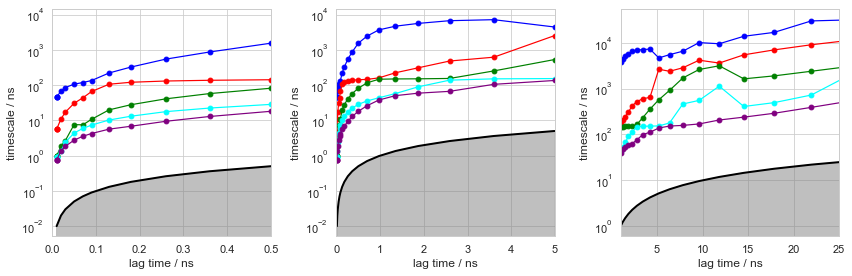

In [95]:
with sns.plotting_context('paper', font_scale=1.25):
    sns.set_style('whitegrid')
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    pm.plots.plot_implied_timescales(its_5, units = 'ns', dt=dt, marker='o', ax=axes[0])
    axes[0].set_xlim(0, 0.5)
    
    pm.plots.plot_implied_timescales(its_5, units = 'ns', dt=dt, marker='o', ax=axes[1])
    axes[1].set_xlim(0, 5)
    
    pm.plots.plot_implied_timescales(its_50, units = 'ns', dt=dt, marker='o', ax=axes[2])
    axes[2].set_xlim(1, 25)
    plt.tight_layout()

In [29]:
def plot(i, j, site='D', **kwargs):
    if(site=='H'):
        states = h_cols
    else:
        states = None
        
    X = df.loc[df['Site']==site, states].values
#     fig, ax = plt.subplots()
    fig, ax = pm.plots.plot_free_energy(X[:, i], X[:, j], cmap='viridis_r', **kwargs)
    ax.set_ylabel(states[j])
    ax.set_xlabel(states[i])
    return ax

In [96]:
mm01 = pm.msm.estimate_markov_model(dtrajs, lag = int(0.1/dt))
mm5 = pm.msm.estimate_markov_model(dtrajs, lag = int(5/dt))

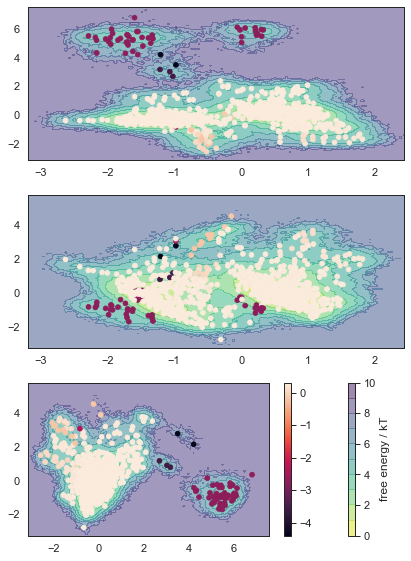

In [118]:
with sns.plotting_context('paper', font_scale=1.25):
    fig = plt.figure(figsize=(6,8))
    sns.set_style('white')
    m = mm01
    for ix, (i, j) in enumerate([[0, 1], [0, 2], [1, 2]]):
        ax = fig.add_subplot(3,1, ix+1)
        if ix == 2:
            cbar=True
        else: 
            cbar=False
#         plot(i, j, 'H', )
        pm.plots.plot_free_energy(np.concatenate(Y)[:, i], np.concatenate(Y)[:, j], cmap='viridis_r', 
                                  **{'avoid_zero_count': True, 'levels': [0,1,2,3,4,5, 6,7, 8, 9, 10], 
                           'ax': ax, 'cbar': cbar, 'alpha':0.5})
        
        c = ax.scatter(cluster.cluster_centers_[m.active_set, i], 
                   cluster.cluster_centers_[m.active_set, j], c=m.eigenvectors_right()[:, 1],)
        if ix==2:
            plt.colorbar(c)
        
    plt.tight_layout()

In [109]:
m.eigenvectors_right()[:, 1]

array([ 0.08194709,  0.29215425,  0.30044715, -2.71846142,  0.30118231,
        0.30036356,  0.300548  ,  0.29997799,  0.29120218,  0.28975481,
        0.25088984,  0.30029417,  0.29071813,  0.28745891,  0.29153391,
        0.28164807,  0.30011251,  0.29976296,  0.30038115,  0.28975498,
        0.3000333 ,  0.30012048, -4.39646259,  0.29818727,  0.15439153,
       -2.72601314,  0.29192871,  0.26972747,  0.29114129,  0.28875971,
        0.29988257, -0.17972453,  0.30015326,  0.29018922,  0.30024189,
        0.28877459,  0.29863622,  0.29038882,  0.28955389,  0.30048853,
        0.3001158 ,  0.2893648 ,  0.28965807,  0.28909587,  0.29083651,
        0.28979783,  0.29999664,  0.29076873,  0.29961564,  0.29931595,
        0.30056801,  0.30047426,  0.25000809, -2.71822494,  0.30021276,
        0.30001248,  0.29242152,  0.29995809,  0.28956983, -3.59596046,
       -2.74546805,  0.30046282,  0.28885759,  0.29033073,  0.30055018,
        0.30045416,  0.2934371 ,  0.26899885,  0.29010234,  0.28